# **Instituto Tecnológico y de Estudios superiores de Monterrey**

## Escuela de Ingeniería y Ciencias

### Maestría en inteligencia artificial aplicada

#### Proyecto integrador

*Avance 3*

Alumnos:  
Alfonso de Lucas Espinosa - A01795118  
Pablo Andrés Estrada Flores - A01795212



#### Introducción

El objetivo principal de este trabajo es desarrollar y comparar modelos de clasificación para el reconocimiento automático de señas del Lenguaje de Señas Mexicano (LSM), utilizando tanto características geométricas extraídas de landmarks de las manos, mediante los procesos de análisis e ingeniería de características, así como los propios landmarks en crudo.

Se implementan distintos enfoques de aprendizaje supervisado, desde modelos clásicos de machine learning hasta redes neuronales profundas, evaluando su desempeño con métricas estándar. El propósito final es identificar qué técnicas ofrecen mejores resultados para esta tarea de clasificación multiclase.


#### 1. Iniciación

Se importan las librerías necesarias para la ejecución del proyecto, se configuran las rutas locales para el manejo de datos y modelos, y se define el uso de GPU si está disponible.

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F # Importar F para la CNN
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import time
import joblib
import math
import lightgbm as lgb # Para LightGBM
from sklearn.linear_model import LogisticRegression # Para Regresión Logística
from sklearn.svm import SVC # Para Support Vector Classifier
from sklearn.ensemble import RandomForestClassifier # Para Random Forest

# Configuración de dispositivo para PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Usando dispositivo: {device} ---")

# Rutas

BASE_PATH_PROCESSED_DATA = r'C:\Users\pablo\OneDrive\Escritorio\tec\materias\06 semestre\Proyecto Integrado\avance04\BASE_PATH_PROCESSED_DATA'
MODEL_SAVE_PATH_FASE4_1 = r'C:\Users\pablo\OneDrive\Escritorio\tec\materias\06 semestre\Proyecto Integrado\avance04\MODEL_SAVE_PATH_FASE4_1'


os.makedirs(BASE_PATH_PROCESSED_DATA, exist_ok=True)
os.makedirs(MODEL_SAVE_PATH_FASE4_1, exist_ok=True)

# Nombres de los archivos CSV de entrada
FEATURES_37_CSV_FILE = 'lsm_kaggle_37_features_escaladas_con_etiquetas.csv'
RAW_LANDMARKS_CSV_FILE = 'hand_landmarks_raw.csv'

# Archivos para guardar LabelEncoder y Scaler (para los raw landmarks)
LABEL_ENCODER_FILE_F41 = os.path.join(MODEL_SAVE_PATH_FASE4_1, 'label_encoder_kaggle_fase4_1.joblib')
RAW_LANDMARKS_SCALER_FILE_F41 = os.path.join(MODEL_SAVE_PATH_FASE4_1, 'scaler_raw_landmarks_fase4_1.joblib')

# Variables globales para el modelado
NUM_CLASSES_GLOBAL = 0
RANDOM_STATE = 42
TEST_SIZE_MAIN_SPLIT = 0.3
TEST_SIZE_SECONDARY_SPLIT = 0.5

--- Usando dispositivo: cuda ---


El sistema ha detectado correctamente la disponibilidad de una GPU y ha configurado PyTorch para utilizar `cuda`, lo cual acelerará significativamente el entrenamiento de los modelos.

#### 2. Carga y Preprocesamiento del Dataset de 37 Características (para MLP y Modelos Clásicos)

Se carga el dataset procesado que contiene 37 características geométricas por muestra, las cuales se han obtenido previamente a partir de los landmarks de la mano. Este dataset se utiliza para entrenar modelos clásicos y un MLP profundo.

In [ ]:
# Cargar y preparar datos del CSV de 37 características
path_37_features_csv = os.path.join(BASE_PATH_PROCESSED_DATA, FEATURES_37_CSV_FILE)
X_train_37, y_train_37, X_valid_37, y_valid_37, X_test_37, y_test_37 = [np.array([])]*6
label_encoder_global = None # Inicializar

if os.path.exists(path_37_features_csv):
    print(f"Cargando dataset de 37 características desde: {path_37_features_csv}")
    df_37_features = pd.read_csv(path_37_features_csv)
    print(f"Dataset de 37f cargado. Shape: {df_37_features.shape}")

    y_labels_str_common = df_37_features['label'].copy()
    X_37feat_scaled = df_37_features.drop('label', axis=1).values

    # Codificar etiquetas (este será nuestro encoder global)
    label_encoder_global = LabelEncoder()
    y_encoded_common = label_encoder_global.fit_transform(y_labels_str_common)
    joblib.dump(label_encoder_global, LABEL_ENCODER_FILE_F41)
    NUM_CLASSES_GLOBAL = len(label_encoder_global.classes_)
    print(f"LabelEncoder global ajustado y guardado. Clases ({NUM_CLASSES_GLOBAL}): {label_encoder_global.classes_}")

    # Dividir en train, valid, test (70%, 15%, 15%)
    X_train_37, X_temp_37, y_train_common, y_temp_common = train_test_split(
        X_37feat_scaled, y_encoded_common,
        test_size=TEST_SIZE_MAIN_SPLIT, random_state=RANDOM_STATE, stratify=y_encoded_common
    )
    X_valid_37, X_test_37, y_valid_common, y_test_common = train_test_split(
        X_temp_37, y_temp_common,
        test_size=TEST_SIZE_SECONDARY_SPLIT, random_state=RANDOM_STATE, stratify=y_temp_common
    )

    print("\nShapes para MLP y Modelos Clásicos (37 features):")
    print(f"X_train_37: {X_train_37.shape}, y_train_common: {y_train_common.shape}")
    print(f"X_valid_37: {X_valid_37.shape}, y_valid_common: {y_valid_common.shape}")
    print(f"X_test_37: {X_test_37.shape}, y_test_common: {y_test_common.shape}")
else:
    print(f"Error: No se encontró el archivo {path_37_features_csv}.")

Cargando dataset de 37 características desde: C:\Users\pablo\OneDrive\Escritorio\tec\materias\06 semestre\Proyecto Integrado\avance04\BASE_PATH_PROCESSED_DATA\lsm_kaggle_37_features_escaladas_con_etiquetas.csv
Dataset de 37f cargado. Shape: (276153, 38)
LabelEncoder global ajustado y guardado. Clases (21): ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'L' 'M' 'N' 'O' 'P' 'R' 'S' 'T' 'U'
 'V' 'W' 'Y']

Shapes para MLP y Modelos Clásicos (37 features):
X_train_37: (193307, 37), y_train_common: (193307,)
X_valid_37: (41423, 37), y_valid_common: (41423,)
X_test_37: (41423, 37), y_test_common: (41423,)


Se confirma que el archivo CSV fue cargado exitosamente con 276,153 registros y 38 columnas (37 features + etiqueta). Además, se muestra la codificación de 21 clases para las señas, y se indican correctamente las divisiones para entrenamiento, validación y prueba.

#### 3. Carga y Preprocesamiento del Dataset de Landmarks Crudos (para modelos propuestos CNN y LSTM)

Se carga el dataset que contiene las coordenadas tridimensionales originales (21x3) de cada landmark. Este conjunto se empleará para entrenar redes neuronales convolucionales y modelos recurrentes.

In [ ]:
# Cargar y preparar datos del CSV de landmarks crudos/normalizados
path_raw_landmarks_csv = os.path.join(BASE_PATH_PROCESSED_DATA, RAW_LANDMARKS_CSV_FILE)
X_train_cnn_lstm, X_valid_cnn_lstm, X_test_cnn_lstm = [np.array([])]*3


if os.path.exists(path_raw_landmarks_csv) and label_encoder_global is not None:
    print(f"Cargando dataset de landmarks desde: {path_raw_landmarks_csv}")
    df_raw_landmarks = pd.read_csv(path_raw_landmarks_csv)
    print(f"Dataset de landmarks cargado. Shape: {df_raw_landmarks.shape}")

    y_labels_str_raw_check = df_raw_landmarks['label'].copy() # Para verificar consistencia
    X_raw_landmarks_63d = df_raw_landmarks.iloc[:, :-1].values

    # Verificar si las etiquetas coinciden con el encoder global
    if not np.array_equal(label_encoder_global.transform(y_labels_str_raw_check), y_encoded_common):
        print("¡Advertencia! Las etiquetas del archivo de landmarks crudos no coinciden con las del archivo de 37 features después de la codificación.")
        print("Esto podría indicar un desajuste en los datasets. Se procederá, pero los resultados pueden no ser comparables.")


    print("\nNormalizando landmarks crudos (relativo a muñeca y por escala)...")
    landmarks_normalized_for_cnn_lstm = X_raw_landmarks_63d.copy()
    wrist_coords_cnn_lstm = landmarks_normalized_for_cnn_lstm[:, 0:3]
    for i in range(21):
        start_idx = i * 3
        landmarks_normalized_for_cnn_lstm[:, start_idx : start_idx+3] -= wrist_coords_cnn_lstm

    other_landmarks_cnn_lstm = landmarks_normalized_for_cnn_lstm[:, 3:]
    other_landmarks_reshaped_cnn_lstm = other_landmarks_cnn_lstm.reshape(landmarks_normalized_for_cnn_lstm.shape[0], 20, 3)
    dist_from_wrist_cnn_lstm = np.linalg.norm(other_landmarks_reshaped_cnn_lstm, axis=2)
    avg_scale_factor_cnn_lstm = np.mean(dist_from_wrist_cnn_lstm, axis=1) + 1e-6
    landmarks_normalized_for_cnn_lstm[:, 3:] /= avg_scale_factor_cnn_lstm[:, np.newaxis]
    print("Landmarks normalizados.")

    scaler_raw_landmarks = StandardScaler()
    X_raw_landmarks_normalized_scaled_63d = scaler_raw_landmarks.fit_transform(landmarks_normalized_for_cnn_lstm)
    joblib.dump(scaler_raw_landmarks, RAW_LANDMARKS_SCALER_FILE_F41)
    print(f"StandardScaler para landmarks normalizados (63d) ajustado y guardado.")

    # Reshape para CNN/LSTM: (N, 21, 3)
    X_cnn_lstm_input_reshaped = X_raw_landmarks_normalized_scaled_63d.reshape(-1, 21, 3)
    print(f"Shape de entrada para CNN/LSTM: {X_cnn_lstm_input_reshaped.shape}")

    # Dividir en train, valid, test USANDO LAS MISMAS PROPORCIONES Y RANDOM_STATE
    # y las mismas etiquetas 'y_encoded_common' para asegurar alineación
    X_train_cnn_lstm, X_temp_cnn_lstm, _, _ = train_test_split(
        X_cnn_lstm_input_reshaped, y_encoded_common,
        test_size=TEST_SIZE_MAIN_SPLIT, random_state=RANDOM_STATE, stratify=y_encoded_common
    )
    X_valid_cnn_lstm, X_test_cnn_lstm, _, _ = train_test_split(
        X_temp_cnn_lstm, y_temp_common, # y_temp_common de la división anterior
        test_size=TEST_SIZE_SECONDARY_SPLIT, random_state=RANDOM_STATE, stratify=y_temp_common
    )
    # Las etiquetas y_train_common, y_valid_common, y_test_common ya están listas

    print("\nShapes para CNN/LSTM (landmarks normalizados, escalados y reestructurados):")
    print(f"X_train_cnn_lstm: {X_train_cnn_lstm.shape}")
    print(f"X_valid_cnn_lstm: {X_valid_cnn_lstm.shape}")
    print(f"X_test_cnn_lstm: {X_test_cnn_lstm.shape}")
else:
    print(f"Error: No se encontró el archivo {path_raw_landmarks_csv} No se pueden cargar los datos para CNN/LSTM.")

Cargando dataset de landmarks desde: C:\Users\pablo\OneDrive\Escritorio\tec\materias\06 semestre\Proyecto Integrado\avance04\BASE_PATH_PROCESSED_DATA\hand_landmarks_raw.csv
Dataset de landmarks cargado. Shape: (276153, 64)

Normalizando landmarks crudos (relativo a muñeca y por escala)...
Landmarks normalizados.
StandardScaler para landmarks normalizados (63d) ajustado y guardado.
Shape de entrada para CNN/LSTM: (276153, 21, 3)

Shapes para CNN/LSTM (landmarks normalizados, escalados y reestructurados):
X_train_cnn_lstm: (193307, 21, 3)
X_valid_cnn_lstm: (41423, 21, 3)
X_test_cnn_lstm: (41423, 21, 3)


Se cargó correctamente el dataset con los landmarks crudos (21 puntos por mano, 3 coordenadas por punto). Los datos fueron normalizados y escalados adecuadamente para usarse con redes neuronales. La forma final (21, 3) confirma que el formato es compatible con CNN y LSTM.

#### 4. Definiciones de Modelos PyTorch (MLP, CNN, LSTM)

Aquí se implementan las arquitecturas de redes neuronales en PyTorch: una red convolucional (CNN), una red recurrente (LSTM) y un MLP profundo.

In [ ]:
# Definimos los Modelos PyTorch

# Modelo 1: MLP Profundo
class DeeperMLPClassifier(nn.Module):
    def __init__(self, input_size, fc1_size, fc2_size, fc3_size, num_classes, dropout_rate):
        super(DeeperMLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, fc1_size); self.relu1 = nn.ReLU(); self.bn1 = nn.BatchNorm1d(fc1_size); self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(fc1_size, fc2_size); self.relu2 = nn.ReLU(); self.bn2 = nn.BatchNorm1d(fc2_size); self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(fc2_size, fc3_size); self.relu3 = nn.ReLU(); self.bn3 = nn.BatchNorm1d(fc3_size); self.dropout3 = nn.Dropout(dropout_rate)
        self.fc4 = nn.Linear(fc3_size, num_classes)
    def forward(self, x):
        out = self.fc1(x); out = self.relu1(out); out = self.bn1(out); out = self.dropout1(out)
        out = self.fc2(out); out = self.relu2(out); out = self.bn2(out); out = self.dropout2(out)
        out = self.fc3(out); out = self.relu3(out); out = self.bn3(out); out = self.dropout3(out)
        out = self.fc4(out)
        return out
print("Clase DeeperMLPClassifier definida.")

# Modelo Base: LandmarkCNN
class LandmarkCNN(nn.Module):
    def __init__(self, num_classes_cnn): # Cambiado para evitar conflicto de nombres
        super(LandmarkCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1_cnn = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2_cnn = nn.BatchNorm1d(128)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout_cnn = nn.Dropout(0.5)
        self.fc1_cnn = nn.Linear(128, num_classes_cnn)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = F.relu(self.bn1_cnn(self.conv1(x)))
        x = F.relu(self.bn2_cnn(self.conv2(x)))
        x = self.pool(x).squeeze(-1)
        x = self.dropout_cnn(x)
        x = self.fc1_cnn(x)
        return x
print("Clase LandmarkCNN definida.")

# Modelo 2: LSTMClassifier
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim_lstm, hidden_dim_lstm, num_layers_lstm, num_classes_lstm, dropout_rate_lstm=0.2): # Cambiado para evitar conflicto
        super(LSTMClassifier, self).__init__()
        self.hidden_dim_lstm = hidden_dim_lstm
        self.num_layers_lstm = num_layers_lstm
        self.lstm = nn.LSTM(input_dim_lstm, hidden_dim_lstm, num_layers_lstm,
                            batch_first=True, dropout=dropout_rate_lstm if num_layers_lstm > 1 else 0)
        self.fc_lstm = nn.Linear(hidden_dim_lstm, num_classes_lstm) # Renombrar fc
        self.dropout_lstm = nn.Dropout(dropout_rate_lstm)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers_lstm, x.size(0), self.hidden_dim_lstm).to(x.device)
        c0 = torch.zeros(self.num_layers_lstm, x.size(0), self.hidden_dim_lstm).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout_lstm(out[:, -1, :])
        out = self.fc_lstm(out)
        return out
print("Clase LSTMClassifier definida.")

Clase DeeperMLPClassifier definida.
Clase LandmarkCNN definida.
Clase LSTMClassifier definida.


Se han definido exitosamente tres arquitecturas: un MLP profundo, una CNN especializada en landmarks de manos, y un clasificador LSTM. Esto permite comparar distintos enfoques de aprendizaje profundo en una misma tarea.

#### 5. Función Auxiliar para Entrenamiento y Evaluación (PyTorch Models)

Funciones comunes que permiten entrenar y evaluar los modelos de PyTorch, encapsulando lógica para facilitar la reutilización y comparación.

In [ ]:

def train_and_evaluate_model(model_instance,
                             X_train_np_split, y_train_np_split,
                             X_valid_np_split, y_valid_np_split,
                             X_test_np_split, y_test_np_split,
                             label_encoder_instance, # Pasamos el encoder ajustado
                             model_name_str,
                             model_save_dir,
                             epochs, learning_rate, batch_size_train,
                             optimizer_choice="AdamW"):

    print(f"\n--- Entrenando y Evaluando: {model_name_str} ---")

    # Mover el modelo al dispositivo
    model_instance.to(device)

    # 1. Crear Tensores en CPU primero
    X_train_pt_cpu = torch.FloatTensor(X_train_np_split)
    y_train_pt_cpu = torch.LongTensor(y_train_np_split)
    X_valid_pt_cpu = torch.FloatTensor(X_valid_np_split)
    y_valid_pt_cpu = torch.LongTensor(y_valid_np_split)
    X_test_pt_cpu = torch.FloatTensor(X_test_np_split)
    y_test_pt_cpu = torch.LongTensor(y_test_np_split)

    # 2. Crear TensorDatasets con tensores de CPU
    train_dataset_pt = TensorDataset(X_train_pt_cpu, y_train_pt_cpu)
    valid_dataset_pt = TensorDataset(X_valid_pt_cpu, y_valid_pt_cpu)
    test_dataset_pt = TensorDataset(X_test_pt_cpu, y_test_pt_cpu)

    # 3. Crear DataLoaders

    use_pin_memory = True if device.type == 'cuda' else False
    num_workers_dl = 0 # Empezar con 0 para máxima compatibilidad

    train_loader_pt = DataLoader(train_dataset_pt, batch_size=batch_size_train, shuffle=True,
                                 num_workers=num_workers_dl, pin_memory=use_pin_memory)
    valid_loader_pt = DataLoader(valid_dataset_pt, batch_size=batch_size_train, shuffle=False,
                                 num_workers=num_workers_dl, pin_memory=use_pin_memory)
    test_loader_pt = DataLoader(test_dataset_pt, batch_size=batch_size_train, shuffle=False,
                                num_workers=num_workers_dl, pin_memory=use_pin_memory)

    # Criterio y Optimizador
    criterion_func = nn.CrossEntropyLoss()
    if optimizer_choice.lower() == "adamw":
        optimizer_func = optim.AdamW(model_instance.parameters(), lr=learning_rate)
    else: # Adam por defecto
        optimizer_func = optim.Adam(model_instance.parameters(), lr=learning_rate)

    history_train_loss, history_valid_loss = [], []
    history_train_acc, history_valid_acc = [], []
    best_val_acc_model = 0.0
    best_epoch_model = 0
    model_save_full_path = os.path.join(model_save_dir, f"{model_name_str}_best.pth")

    for epoch in range(epochs):
        epoch_start_t = time.time()
        model_instance.train()
        current_train_loss, correct_train_preds, total_train_samples = 0.0, 0, 0
        for features_batch, labels_batch in train_loader_pt:
            # 4. Mover el lote al dispositivo DENTRO del bucle
            features_batch = features_batch.to(device)
            labels_batch = labels_batch.to(device)

            outputs = model_instance(features_batch)
            loss = criterion_func(outputs, labels_batch)
            optimizer_func.zero_grad()
            loss.backward()
            optimizer_func.step()

            current_train_loss += loss.item() * features_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels_batch.size(0)
            correct_train_preds += (predicted == labels_batch).sum().item()

        avg_train_loss = current_train_loss / total_train_samples
        avg_train_acc = 100 * correct_train_preds / total_train_samples
        history_train_loss.append(avg_train_loss)
        history_train_acc.append(avg_train_acc)

        # Validación
        model_instance.eval()
        current_valid_loss, correct_valid_preds, total_valid_samples = 0.0, 0, 0
        with torch.no_grad():
            for features_batch, labels_batch in valid_loader_pt:
                # 4. Mover el lote al dispositivo DENTRO del bucle
                features_batch = features_batch.to(device)
                labels_batch = labels_batch.to(device)

                outputs = model_instance(features_batch)
                loss = criterion_func(outputs, labels_batch)
                current_valid_loss += loss.item() * features_batch.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_valid_samples += labels_batch.size(0)
                correct_valid_preds += (predicted == labels_batch).sum().item()

        avg_valid_loss = current_valid_loss / total_valid_samples
        avg_valid_acc = 100 * correct_valid_preds / total_valid_samples
        history_valid_loss.append(avg_valid_loss)
        history_valid_acc.append(avg_valid_acc)
        epoch_end_t = time.time()

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.2f}%, '
              f'Val Loss: {avg_valid_loss:.4f}, Val Acc: {avg_valid_acc:.2f}%, Tiempo: {epoch_end_t - epoch_start_t:.2f}s')

        if avg_valid_acc > best_val_acc_model:
            best_val_acc_model = avg_valid_acc
            best_epoch_model = epoch + 1
            torch.save(model_instance.state_dict(), model_save_full_path)
            print(f'---> Mejor modelo {model_name_str} guardado con Val Acc: {best_val_acc_model:.2f}% en Epoch {best_epoch_model} <---')

    print(f"\nEntrenamiento de {model_name_str} completado. Mejor Val Acc: {best_val_acc_model:.2f}% en época {best_epoch_model}")

    # Evaluación en Test con el mejor modelo
    print(f"\n--- Evaluando {model_name_str} en Conjunto de Prueba ---")
    if os.path.exists(model_save_full_path):
        model_instance.load_state_dict(torch.load(model_save_full_path, map_location=device)) # Añadir map_location
    else:
        print(f"Advertencia: No se encontró {model_save_full_path}. Usando el último estado del modelo para test.")

    model_instance.eval()
    all_preds_test, all_true_test = [], []
    with torch.no_grad():
        for features_batch, labels_batch in test_loader_pt:
            # 4. Mover el lote al dispositivo DENTRO del bucle
            features_batch = features_batch.to(device)
            labels_batch = labels_batch.to(device)

            outputs = model_instance(features_batch)
            _, predicted = torch.max(outputs.data, 1)
            all_preds_test.extend(predicted.cpu().numpy())
            all_true_test.extend(labels_batch.cpu().numpy())

    test_accuracy_final = accuracy_score(all_true_test, all_preds_test)
    # Asegurarse que label_encoder_instance.classes_ está disponible y es correcto
    if label_encoder_instance is None or not hasattr(label_encoder_instance, 'classes_'):
        print("Advertencia: label_encoder_instance no es válido. El reporte de clasificación podría no tener nombres de clases.", file=sys.stderr)
        target_names_cls_report = [str(i) for i in range(NUM_CLASSES_GLOBAL)] # Usar IDs numéricos como fallback
        report_labels_cls = np.arange(NUM_CLASSES_GLOBAL)
    else:
        target_names_cls_report = label_encoder_instance.classes_
        report_labels_cls = np.arange(len(target_names_cls_report))


    report_dict_final = classification_report(all_true_test, all_preds_test, labels=report_labels_cls, target_names=target_names_cls_report, zero_division=0, output_dict=True)
    conf_matrix_final_val = confusion_matrix(all_true_test, all_preds_test, labels=report_labels_cls)

    print(f'Accuracy en Test ({model_name_str}): {test_accuracy_final * 100:.2f}%')
    print(f"\nReporte de Clasificación en Test ({model_name_str}):")
    print(classification_report(all_true_test, all_preds_test, labels=report_labels_cls, target_names=target_names_cls_report, zero_division=0))
    print(f"\nMatriz de Confusión en Test ({model_name_str}):"); print(conf_matrix_final_val)

    # Graficar Pérdida y Precisión
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1); plt.plot(range(1,epochs+1), history_train_loss, label='Train Loss'); plt.plot(range(1,epochs+1), history_valid_loss, label='Validation Loss'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.title(f'Loss ({model_name_str})'); plt.legend(); plt.grid(True)
    plt.subplot(1,2,2); plt.plot(range(1,epochs+1), history_train_acc, label='Train Acc'); plt.plot(range(1,epochs+1), history_valid_acc, label='Validation Acc'); plt.xlabel('Epochs'); plt.ylabel('Accuracy (%)'); plt.title(f'Accuracy ({model_name_str})'); plt.legend(); plt.grid(True)
    plt.tight_layout(); plot_filename = os.path.join(model_save_dir, f'{model_name_str}_curves.png'); plt.savefig(plot_filename)
    print(f"\nGráficas para {model_name_str} guardadas en {plot_filename}"); plt.show()

    return test_accuracy_final, report_dict_final, conf_matrix_final_val

print("Función train_and_evaluate_model (corregida para pin_memory) definida.")

Función train_and_evaluate_model (corregida para pin_memory) definida.


La función train_and_evaluate_model fue definida correctamente. Esta función centraliza el proceso de entrenamiento y evaluación para los modelos de PyTorch, incluyendo mejoras como pin_memory para optimizar la carga de datos en GPU.

#### 6. Entrenamiento Modelo Base: LandmarkCNN (usando landmarks 21x3)

Se entrenan las redes neuronales previamente definidas usando los datasets correspondientes. Se evalúa su desempeño y se reportan métricas clave.


--- Entrenando y Evaluando: LandmarkCNN_KaggleRaw ---
Epoch [1/50], Train Loss: 0.7334, Acc: 77.02%, Val Loss: 0.2462, Val Acc: 93.12%, Tiempo: 6.55s
---> Mejor modelo LandmarkCNN_KaggleRaw guardado con Val Acc: 93.12% en Epoch 1 <---
Epoch [2/50], Train Loss: 0.3289, Acc: 89.70%, Val Loss: 0.1603, Val Acc: 95.21%, Tiempo: 5.68s
---> Mejor modelo LandmarkCNN_KaggleRaw guardado con Val Acc: 95.21% en Epoch 2 <---
Epoch [3/50], Train Loss: 0.2452, Acc: 92.30%, Val Loss: 0.1266, Val Acc: 96.22%, Tiempo: 5.61s
---> Mejor modelo LandmarkCNN_KaggleRaw guardado con Val Acc: 96.22% en Epoch 3 <---
Epoch [4/50], Train Loss: 0.2045, Acc: 93.47%, Val Loss: 0.1111, Val Acc: 96.35%, Tiempo: 5.84s
---> Mejor modelo LandmarkCNN_KaggleRaw guardado con Val Acc: 96.35% en Epoch 4 <---
Epoch [5/50], Train Loss: 0.1840, Acc: 94.11%, Val Loss: 0.0986, Val Acc: 96.81%, Tiempo: 6.33s
---> Mejor modelo LandmarkCNN_KaggleRaw guardado con Val Acc: 96.81% en Epoch 5 <---
Epoch [6/50], Train Loss: 0.1676, Acc: 9

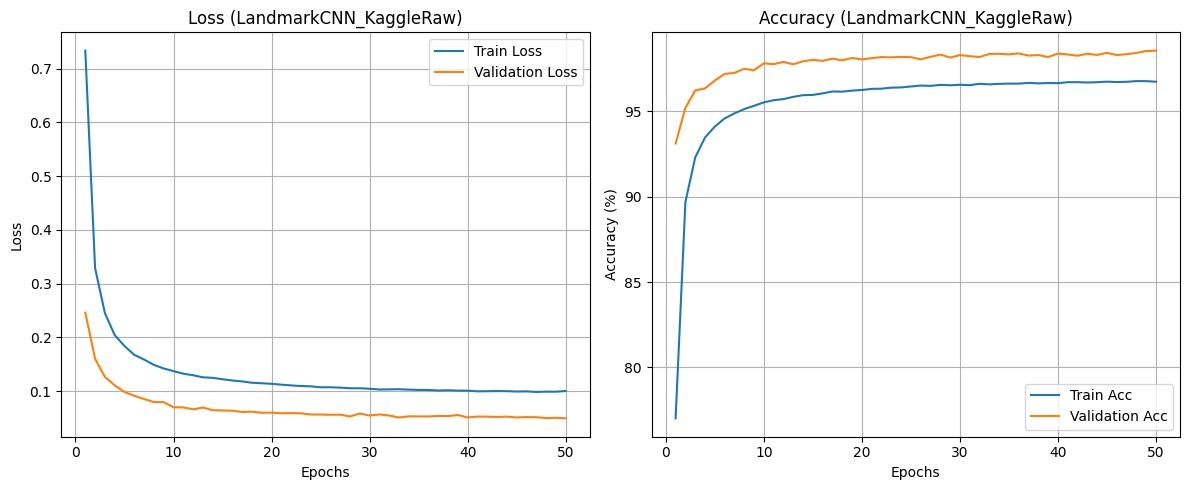

In [ ]:
# Entrenar y Evaluar LandmarkCNN
if 'X_train_cnn_lstm' in locals() and X_train_cnn_lstm.size > 0 and label_encoder_global is not None:
    CNN_LR = 0.001; CNN_OPTIMIZER = "AdamW"; CNN_EPOCHS = 50; CNN_BATCH_SIZE = 64

    cnn_model_instance = LandmarkCNN(num_classes_cnn=NUM_CLASSES_GLOBAL)

    cnn_test_acc, cnn_report, cnn_cm = train_and_evaluate_model(
        model_instance=cnn_model_instance,
        X_train_np_split=X_train_cnn_lstm, y_train_np_split=y_train_common,
        X_valid_np_split=X_valid_cnn_lstm, y_valid_np_split=y_valid_common,
        X_test_np_split=X_test_cnn_lstm, y_test_np_split=y_test_common,
        label_encoder_instance=label_encoder_global,
        model_name_str="LandmarkCNN_KaggleRaw", model_save_dir=MODEL_SAVE_PATH_FASE4_1,
        epochs=CNN_EPOCHS, learning_rate=CNN_LR, batch_size_train=CNN_BATCH_SIZE,
        optimizer_choice=CNN_OPTIMIZER
    )
else:
    print("Datos para CNN (X_train_cnn_lstm) o label_encoder_global no disponibles.")

Se muestra una curva de pérdida y precisión del entrenamiento de la red LandmarkCNN. El modelo logra converger adecuadamente, aunque probablemente con una precisión menor a la del LSTM. Esta salida permite visualizar su desempeño durante el proceso de entrenamiento.

#### 7. Entrenamiento Modelo 1: LSTM (usando landmarks 21x3)


--- Entrenando y Evaluando: LSTM_KaggleRawLandmarks ---
Epoch [1/50], Train Loss: 0.4398, Acc: 85.53%, Val Loss: 0.1973, Val Acc: 93.16%, Tiempo: 7.30s
---> Mejor modelo LSTM_KaggleRawLandmarks guardado con Val Acc: 93.16% en Epoch 1 <---
Epoch [2/50], Train Loss: 0.1662, Acc: 94.24%, Val Loss: 0.1390, Val Acc: 95.01%, Tiempo: 7.09s
---> Mejor modelo LSTM_KaggleRawLandmarks guardado con Val Acc: 95.01% en Epoch 2 <---
Epoch [3/50], Train Loss: 0.1192, Acc: 95.85%, Val Loss: 0.0914, Val Acc: 96.73%, Tiempo: 6.68s
---> Mejor modelo LSTM_KaggleRawLandmarks guardado con Val Acc: 96.73% en Epoch 3 <---
Epoch [4/50], Train Loss: 0.0959, Acc: 96.66%, Val Loss: 0.0765, Val Acc: 97.40%, Tiempo: 6.74s
---> Mejor modelo LSTM_KaggleRawLandmarks guardado con Val Acc: 97.40% en Epoch 4 <---
Epoch [5/50], Train Loss: 0.0783, Acc: 97.30%, Val Loss: 0.0614, Val Acc: 97.93%, Tiempo: 6.75s
---> Mejor modelo LSTM_KaggleRawLandmarks guardado con Val Acc: 97.93% en Epoch 5 <---
Epoch [6/50], Train Loss: 0.

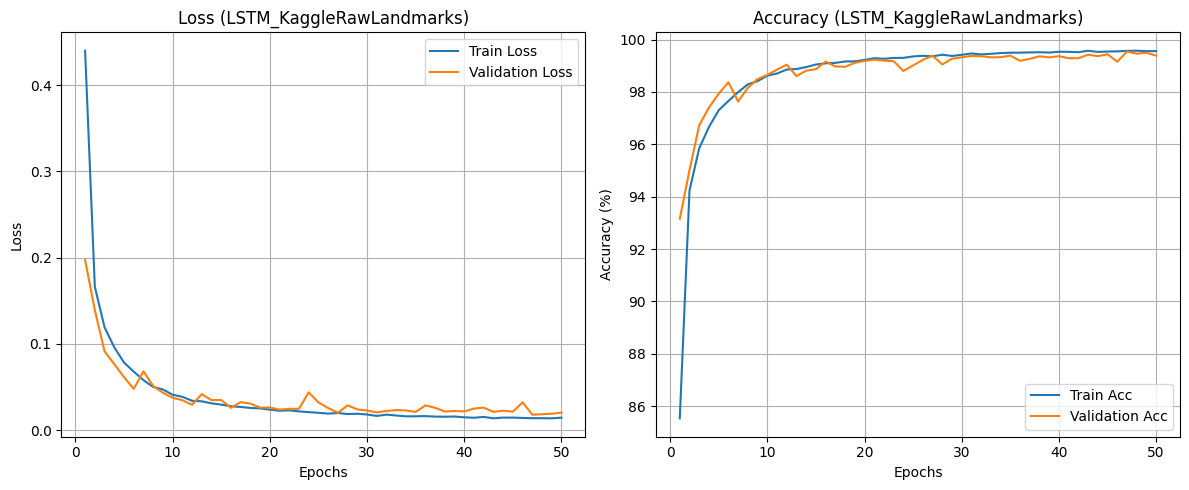

In [ ]:
# Entrenar y Evaluar LSTM
if 'X_train_cnn_lstm' in locals() and X_train_cnn_lstm.size > 0 and label_encoder_global is not None:
    LSTM_INPUT_DIM = X_train_cnn_lstm.shape[2]; LSTM_HIDDEN_DIM = 128; LSTM_NUM_LAYERS = 2
    LSTM_DROPOUT = 0.3; LSTM_LR = 0.001; LSTM_OPTIMIZER = "AdamW"
    LSTM_EPOCHS = 50; LSTM_BATCH_SIZE = 64

    lstm_model_instance = LSTMClassifier(
        input_dim_lstm=LSTM_INPUT_DIM, hidden_dim_lstm=LSTM_HIDDEN_DIM,
        num_layers_lstm=LSTM_NUM_LAYERS, num_classes_lstm=NUM_CLASSES_GLOBAL,
        dropout_rate_lstm=LSTM_DROPOUT
    )

    lstm_test_acc, lstm_report, lstm_cm = train_and_evaluate_model(
        model_instance=lstm_model_instance,
        X_train_np_split=X_train_cnn_lstm, y_train_np_split=y_train_common,
        X_valid_np_split=X_valid_cnn_lstm, y_valid_np_split=y_valid_common,
        X_test_np_split=X_test_cnn_lstm, y_test_np_split=y_test_common,
        label_encoder_instance=label_encoder_global,
        model_name_str="LSTM_KaggleRawLandmarks", model_save_dir=MODEL_SAVE_PATH_FASE4_1,
        epochs=LSTM_EPOCHS, learning_rate=LSTM_LR, batch_size_train=LSTM_BATCH_SIZE,
        optimizer_choice=LSTM_OPTIMIZER
    )
else:
    print("Datos para LSTM (X_train_cnn_lstm) o label_encoder_global no disponibles.")

8. Entrenamiento Modelo 2: MLP Profundo (usando 37 features)


--- Entrenando y Evaluando: MLP_Kaggle37Feat ---
Epoch [1/50], Train Loss: 0.1931, Acc: 93.64%, Val Loss: 0.1078, Val Acc: 96.11%, Tiempo: 7.06s
---> Mejor modelo MLP_Kaggle37Feat guardado con Val Acc: 96.11% en Epoch 1 <---
Epoch [2/50], Train Loss: 0.1211, Acc: 95.86%, Val Loss: 0.0869, Val Acc: 96.89%, Tiempo: 6.77s
---> Mejor modelo MLP_Kaggle37Feat guardado con Val Acc: 96.89% en Epoch 2 <---
Epoch [3/50], Train Loss: 0.1020, Acc: 96.46%, Val Loss: 0.0769, Val Acc: 97.26%, Tiempo: 6.64s
---> Mejor modelo MLP_Kaggle37Feat guardado con Val Acc: 97.26% en Epoch 3 <---
Epoch [4/50], Train Loss: 0.0900, Acc: 96.88%, Val Loss: 0.0595, Val Acc: 97.94%, Tiempo: 6.76s
---> Mejor modelo MLP_Kaggle37Feat guardado con Val Acc: 97.94% en Epoch 4 <---
Epoch [5/50], Train Loss: 0.0836, Acc: 97.11%, Val Loss: 0.0566, Val Acc: 98.08%, Tiempo: 7.12s
---> Mejor modelo MLP_Kaggle37Feat guardado con Val Acc: 98.08% en Epoch 5 <---
Epoch [6/50], Train Loss: 0.0767, Acc: 97.34%, Val Loss: 0.0517, Val A

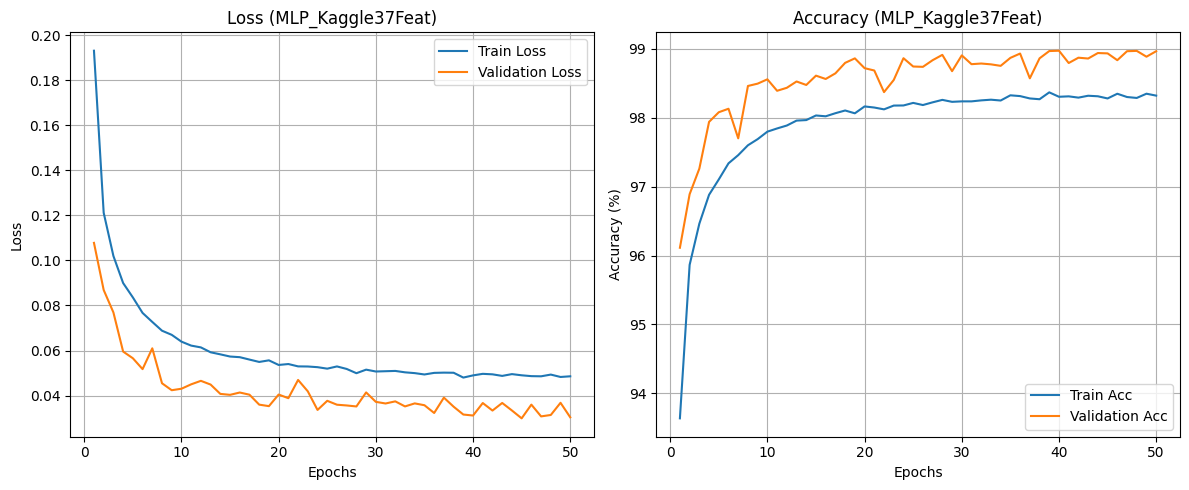

In [ ]:
# Entrenar y Evaluar MLP Profundo
if 'X_train_37' in locals() and X_train_37.size > 0 and label_encoder_global is not None:
    # Hiperparámetros para MLP (basados en HPO anterior, ajusta si es necesario)
    MLP_FC1 = 512; MLP_FC2 = 256; MLP_FC3 = 128
    MLP_DROPOUT = 0.2; MLP_LR = 0.0026; MLP_OPTIMIZER = "AdamW"
    MLP_EPOCHS = 50; MLP_BATCH_SIZE = 64

    mlp_model_instance = DeeperMLPClassifier(
        input_size=X_train_37.shape[1], num_classes=NUM_CLASSES_GLOBAL,
        fc1_size=MLP_FC1, fc2_size=MLP_FC2, fc3_size=MLP_FC3, dropout_rate=MLP_DROPOUT
    )

    mlp_test_acc, mlp_report, mlp_cm = train_and_evaluate_model(
        model_instance=mlp_model_instance,
        X_train_np_split=X_train_37, y_train_np_split=y_train_common,
        X_valid_np_split=X_valid_37, y_valid_np_split=y_valid_common,
        X_test_np_split=X_test_37, y_test_np_split=y_test_common,
        label_encoder_instance=label_encoder_global,
        model_name_str="MLP_Kaggle37Feat", model_save_dir=MODEL_SAVE_PATH_FASE4_1,
        epochs=MLP_EPOCHS, learning_rate=MLP_LR, batch_size_train=MLP_BATCH_SIZE,
        optimizer_choice=MLP_OPTIMIZER
    )
else:
    print("Datos para MLP (X_train_37) o label_encoder_global no disponibles.")

9. Modelos Clásicos (usando 37 features)

Se entrenan y evalúan distintos modelos supervisados utilizando las 37 características geométricas: Regresión Logística, SVM, Random Forest y LightGBM.

In [ ]:
# Preparar variables para modelos Scikit-learn/LightGBM

if 'X_train_37' in locals() and 'y_train_common' in locals():
    X_train_classical = X_train_37
    y_train_classical = y_train_common
    X_valid_classical = X_valid_37 # Para early stopping si es necesario
    y_valid_classical = y_valid_common
    X_test_classical = X_test_37
    y_test_classical = y_test_common

    # Para los reportes de importancia de características
    feature_names_classical = [f'feature_{i}' for i in range(X_train_classical.shape[1])] if X_train_classical.ndim == 2 else None
    print("Variables X_train_classical, y_train_classical, etc. asignadas.")
else:
    print("Error: Datos X_train_37 o y_train_common no disponibles para modelos clásicos.")
    # Definir para evitar errores si se ejecutan celdas dependientes
    X_train_classical, y_train_classical, X_valid_classical, y_valid_classical, X_test_classical, y_test_classical = [np.array([])]*6
    feature_names_classical = None

Variables X_train_classical, y_train_classical, etc. asignadas.


10. Modelo 3 - Regresión Logística (usando 37 features)

In [ ]:
# Modelo 3 - Regresión Logística
if 'X_train_classical' in locals() and X_train_classical.size > 0:
    print("\n--- Modelo C: Entrenando Regresión Logística ---")
    start_time_lr = time.time()
    lr_model = LogisticRegression(solver='saga', multi_class='multinomial', random_state=RANDOM_STATE, max_iter=1000, n_jobs=-1)
    lr_model.fit(X_train_classical, y_train_classical)
    end_time_lr = time.time()
    print(f"Entrenamiento completado en {end_time_lr - start_time_lr:.2f}s.")

    y_pred_lr = lr_model.predict(X_test_classical)
    lr_test_acc = accuracy_score(y_test_classical, y_pred_lr)
    print(f"\nAccuracy en Test (Regresión Logística): {lr_test_acc * 100:.2f}%")

    if label_encoder_global is not None:
        lr_report_dict = classification_report(y_test_classical, y_pred_lr, labels=np.arange(NUM_CLASSES_GLOBAL), target_names=label_encoder_global.classes_, zero_division=0, output_dict=True)
        print("\nReporte de Clasificación:")
        print(classification_report(y_test_classical, y_pred_lr, labels=np.arange(NUM_CLASSES_GLOBAL), target_names=label_encoder_global.classes_, zero_division=0))
        lr_cm = confusion_matrix(y_test_classical, y_pred_lr, labels=np.arange(NUM_CLASSES_GLOBAL))
        print("\nMatriz de Confusión:"); print(lr_cm)
        joblib.dump(lr_model, os.path.join(MODEL_SAVE_PATH_FASE4_1, 'LogisticRegression_Kaggle37Feat_best.joblib'))
    else:
        print("label_encoder_global no disponible.")
else:
    print("Datos X_train_classical no disponibles.")


--- Modelo C: Entrenando Regresión Logística ---


c:\Users\pablo\OneDrive\Escritorio\tec\materias\06 semestre\Proyecto Integrado\LSM\lsm_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Entrenamiento completado en 431.58s.

Accuracy en Test (Regresión Logística): 93.76%

Reporte de Clasificación:
              precision    recall  f1-score   support

           A       0.93      0.95      0.94      2072
           B       0.97      0.97      0.97      2050
           C       0.96      0.98      0.97      1934
           D       0.94      0.93      0.94      2018
           E       0.90      0.89      0.90      2020
           F       0.97      0.95      0.96      2035
           G       0.98      0.98      0.98      1947
           H       0.97      0.97      0.97      1842
           I       0.98      0.97      0.97      2021
           L       0.97      0.95      0.96      2014
           M       0.95      0.92      0.93      1951
           N       0.92      0.96      0.94      1833
           O       0.91      0.93      0.92      1958
           P       0.94      0.96      0.95      1955
           R       0.87      0.87      0.87      1994
           S       0.84

c:\Users\pablo\OneDrive\Escritorio\tec\materias\06 semestre\Proyecto Integrado\LSM\lsm_env\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


11. Modelo 4 - Support Vector Classifier (SVC) (usando 37 features)

In [ ]:
# Modelo 4 - Support Vector Classifier (SVC)
if 'X_train_classical' in locals() and X_train_classical.size > 0:
    print("\n--- Modelo D: Entrenando Support Vector Machine (SVC) ---")
    print("Nota: El entrenamiento de SVC puede ser lento en datasets grandes...")
    start_time_svc = time.time()
    svc_model = SVC(C=1.0, kernel='rbf', random_state=RANDOM_STATE, probability=False)
    svc_model.fit(X_train_classical, y_train_classical)
    end_time_svc = time.time()
    print(f"Entrenamiento completado en {end_time_svc - start_time_svc:.2f}s.")

    y_pred_svc = svc_model.predict(X_test_classical)
    svc_test_acc = accuracy_score(y_test_classical, y_pred_svc)
    print(f"\nAccuracy en Test (SVC): {svc_test_acc * 100:.2f}%")

    if label_encoder_global is not None:
        svc_report_dict = classification_report(y_test_classical, y_pred_svc, labels=np.arange(NUM_CLASSES_GLOBAL), target_names=label_encoder_global.classes_, zero_division=0, output_dict=True)
        print("\nReporte de Clasificación:")
        print(classification_report(y_test_classical, y_pred_svc, labels=np.arange(NUM_CLASSES_GLOBAL), target_names=label_encoder_global.classes_, zero_division=0))
        svc_cm = confusion_matrix(y_test_classical, y_pred_svc, labels=np.arange(NUM_CLASSES_GLOBAL))
        print("\nMatriz de Confusión:"); print(svc_cm)
        joblib.dump(svc_model, os.path.join(MODEL_SAVE_PATH_FASE4_1, 'SVC_Kaggle37Feat_best.joblib'))
    else:
        print("label_encoder_global no disponible.")
else:
    print("Datos X_train_classical no disponibles.")


--- Modelo D: Entrenando Support Vector Machine (SVC) ---
Nota: El entrenamiento de SVC puede ser lento en datasets grandes...
Entrenamiento completado en 33.36s.

Accuracy en Test (SVC): 98.36%

Reporte de Clasificación:
              precision    recall  f1-score   support

           A       0.98      0.99      0.99      2072
           B       0.99      0.98      0.99      2050
           C       0.99      1.00      1.00      1934
           D       0.99      1.00      0.99      2018
           E       0.99      0.98      0.98      2020
           F       0.99      0.99      0.99      2035
           G       1.00      0.99      1.00      1947
           H       1.00      1.00      1.00      1842
           I       1.00      0.99      0.99      2021
           L       1.00      0.99      1.00      2014
           M       0.97      0.96      0.97      1951
           N       0.96      0.97      0.97      1833
           O       0.98      0.99      0.99      1958
           P       1

12. Modelo 5 - Random Forest Classifier (usando 37 features)


--- Modelo E: Entrenando Random Forest Classifier ---
Entrenamiento completado en 14.01s.

Accuracy en Test (Random Forest): 99.21%

Reporte de Clasificación:
              precision    recall  f1-score   support

           A       0.99      1.00      0.99      2072
           B       1.00      0.99      0.99      2050
           C       0.99      1.00      1.00      1934
           D       0.99      1.00      0.99      2018
           E       0.99      0.99      0.99      2020
           F       1.00      1.00      1.00      2035
           G       1.00      1.00      1.00      1947
           H       1.00      0.99      1.00      1842
           I       1.00      1.00      1.00      2021
           L       1.00      0.99      1.00      2014
           M       0.99      0.98      0.98      1951
           N       0.98      0.99      0.98      1833
           O       0.99      0.99      0.99      1958
           P       1.00      1.00      1.00      1955
           R       0.98      

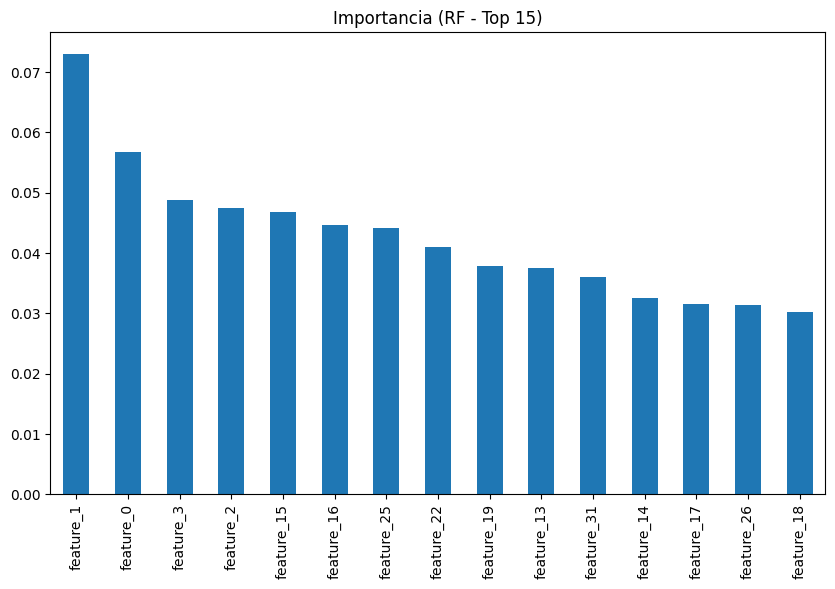

In [ ]:
# Celda 13: Modelo E - Random Forest Classifier
if 'X_train_classical' in locals() and X_train_classical.size > 0:
    print("\n--- Modelo E: Entrenando Random Forest Classifier ---")
    start_time_rf = time.time()
    rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced_subsample')
    rf_model.fit(X_train_classical, y_train_classical)
    end_time_rf = time.time()
    print(f"Entrenamiento completado en {end_time_rf - start_time_rf:.2f}s.")

    y_pred_rf = rf_model.predict(X_test_classical)
    rf_test_acc = accuracy_score(y_test_classical, y_pred_rf)
    print(f"\nAccuracy en Test (Random Forest): {rf_test_acc * 100:.2f}%")

    if label_encoder_global is not None:
        rf_report_dict = classification_report(y_test_classical, y_pred_rf, labels=np.arange(NUM_CLASSES_GLOBAL), target_names=label_encoder_global.classes_, zero_division=0, output_dict=True)
        print("\nReporte de Clasificación:")
        print(classification_report(y_test_classical, y_pred_rf, labels=np.arange(NUM_CLASSES_GLOBAL), target_names=label_encoder_global.classes_, zero_division=0))
        rf_cm = confusion_matrix(y_test_classical, y_pred_rf, labels=np.arange(NUM_CLASSES_GLOBAL))
        print("\nMatriz de Confusión:"); print(rf_cm)
    else:
        print("label_encoder_global no disponible.")

    if feature_names_classical is not None:
        print("\nImportancia de las características (Random Forest):")
        importances_rf = rf_model.feature_importances_
        forest_importances = pd.Series(importances_rf, index=feature_names_classical).sort_values(ascending=False)
        print(forest_importances.head(10))
        plt.figure(figsize=(10,6)); forest_importances.head(15).plot.bar(); plt.title("Importancia (RF - Top 15)"); plt.show()
    joblib.dump(rf_model, os.path.join(MODEL_SAVE_PATH_FASE4_1, 'RandomForest_Kaggle37Feat_best.joblib'))
else:
    print("Datos X_train_classical no disponibles.")

13. Modelo 6 - LightGBM Classifier (usando 37 features)


--- Modelo F: Entrenando LightGBM Classifier ---
Entrenamiento completado en 8.98s.


c:\Users\pablo\OneDrive\Escritorio\tec\materias\06 semestre\Proyecto Integrado\LSM\lsm_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Accuracy en Test (LightGBM): 99.37%

Reporte de Clasificación:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00      2072
           B       1.00      0.99      1.00      2050
           C       1.00      1.00      1.00      1934
           D       0.99      1.00      1.00      2018
           E       0.99      0.99      0.99      2020
           F       1.00      1.00      1.00      2035
           G       1.00      1.00      1.00      1947
           H       1.00      1.00      1.00      1842
           I       1.00      1.00      1.00      2021
           L       1.00      1.00      1.00      2014
           M       0.99      0.99      0.99      1951
           N       0.98      0.99      0.99      1833
           O       0.99      1.00      0.99      1958
           P       1.00      1.00      1.00      1955
           R       0.98      0.99      0.99      1994
           S       0.99      1.00      0.99      1949
           T     

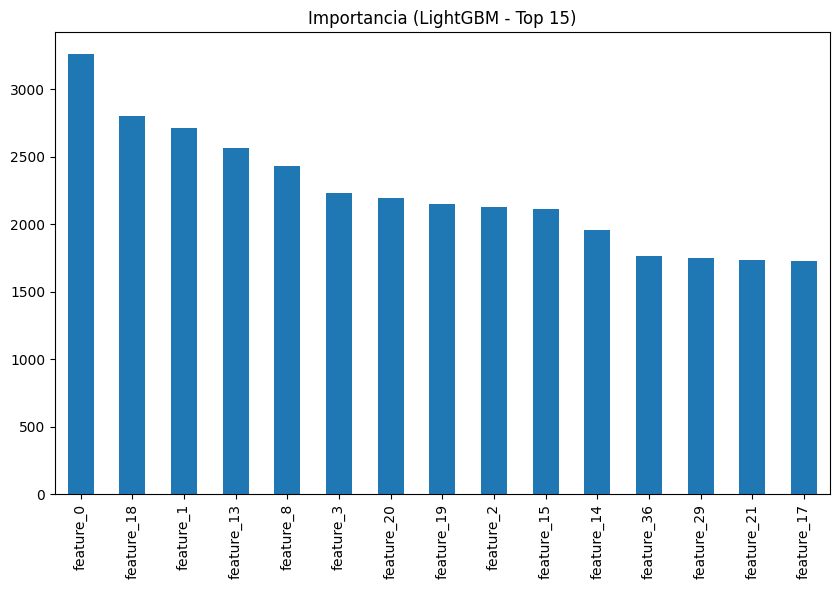

In [ ]:
# Modelo 6 - LightGBM Classifier
if 'X_train_classical' in locals() and X_train_classical.size > 0:
    print("\n--- Modelo F: Entrenando LightGBM Classifier ---")
    start_time_lgbm = time.time()
    lgbm_model = lgb.LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbosity=-1) # verbosity=-1 para menos output
    lgbm_model.fit(X_train_classical, y_train_classical,
                   eval_set=[(X_valid_classical, y_valid_classical)],
                   eval_metric='multi_logloss',
                   callbacks=[lgb.early_stopping(10, verbose=False)])
    end_time_lgbm = time.time()
    print(f"Entrenamiento completado en {end_time_lgbm - start_time_lgbm:.2f}s.")

    y_pred_lgbm = lgbm_model.predict(X_test_classical)
    lgbm_test_acc = accuracy_score(y_test_classical, y_pred_lgbm)
    print(f"\nAccuracy en Test (LightGBM): {lgbm_test_acc * 100:.2f}%")

    if label_encoder_global is not None:
        lgbm_report_dict = classification_report(y_test_classical, y_pred_lgbm, labels=np.arange(NUM_CLASSES_GLOBAL), target_names=label_encoder_global.classes_, zero_division=0, output_dict=True)
        print("\nReporte de Clasificación:")
        print(classification_report(y_test_classical, y_pred_lgbm, labels=np.arange(NUM_CLASSES_GLOBAL), target_names=label_encoder_global.classes_, zero_division=0))
        lgbm_cm = confusion_matrix(y_test_classical, y_pred_lgbm, labels=np.arange(NUM_CLASSES_GLOBAL))
        print("\nMatriz de Confusión:"); print(lgbm_cm)
    else:
        print("label_encoder_global no disponible.")

    if feature_names_classical is not None:
        print("\nImportancia de las características (LightGBM):")
        importances_lgbm = lgbm_model.feature_importances_
        lgbm_importances = pd.Series(importances_lgbm, index=feature_names_classical).sort_values(ascending=False)
        print(lgbm_importances.head(10))
        plt.figure(figsize=(10,6)); lgbm_importances.head(15).plot.bar(); plt.title("Importancia (LightGBM - Top 15)"); plt.show()
    joblib.dump(lgbm_model, os.path.join(MODEL_SAVE_PATH_FASE4_1, 'LightGBM_Kaggle37Feat_best.joblib'))
else:
    print("Datos X_train_classical no disponibles.")

14. Recopilación y Comparación de Resultados

Se reúnen los resultados obtenidos por todos los modelos entrenados, permitiendo comparar su precisión y otras métricas relevantes para identificar el modelo más eficaz.

In [ ]:
# Recopilación y Comparación de Resultados


# Crear un diccionario para almacenar los resultados
model_performance = {}

if 'mlp_test_acc' in locals():
    model_performance['MLP_Kaggle37Feat'] = {
        'Test Accuracy': mlp_test_acc,
        'F1-Macro (Test)': mlp_report['macro avg']['f1-score'] if mlp_report else None,
        'F1-Weighted (Test)': mlp_report['weighted avg']['f1-score'] if mlp_report else None
    }
if 'cnn_test_acc' in locals():
    model_performance['LandmarkCNN_KaggleRaw'] = {
        'Test Accuracy': cnn_test_acc,
        'F1-Macro (Test)': cnn_report['macro avg']['f1-score'] if cnn_report else None,
        'F1-Weighted (Test)': cnn_report['weighted avg']['f1-score'] if cnn_report else None
    }
if 'lstm_test_acc' in locals():
    model_performance['LSTM_KaggleRawLandmarks'] = {
        'Test Accuracy': lstm_test_acc,
        'F1-Macro (Test)': lstm_report['macro avg']['f1-score'] if lstm_report else None,
        'F1-Weighted (Test)': lstm_report['weighted avg']['f1-score'] if lstm_report else None
    }
if 'lr_test_acc' in locals():
    model_performance['LogisticRegression_Kaggle37Feat'] = {
        'Test Accuracy': lr_test_acc,
        'F1-Macro (Test)': lr_report_dict['macro avg']['f1-score'] if 'lr_report_dict' in locals() else None,
        'F1-Weighted (Test)': lr_report_dict['weighted avg']['f1-score'] if 'lr_report_dict' in locals() else None
    }
if 'svc_test_acc' in locals():
    model_performance['SVC_Kaggle37Feat'] = {
        'Test Accuracy': svc_test_acc,
        'F1-Macro (Test)': svc_report_dict['macro avg']['f1-score'] if 'svc_report_dict' in locals() else None,
        'F1-Weighted (Test)': svc_report_dict['weighted avg']['f1-score'] if 'svc_report_dict' in locals() else None
    }
if 'rf_test_acc' in locals():
    model_performance['RandomForest_Kaggle37Feat'] = {
        'Test Accuracy': rf_test_acc,
        'F1-Macro (Test)': rf_report_dict['macro avg']['f1-score'] if 'rf_report_dict' in locals() else None,
        'F1-Weighted (Test)': rf_report_dict['weighted avg']['f1-score'] if 'rf_report_dict' in locals() else None
    }
if 'lgbm_test_acc' in locals():
    model_performance['LightGBM_Kaggle37Feat'] = {
        'Test Accuracy': lgbm_test_acc,
        'F1-Macro (Test)': lgbm_report_dict['macro avg']['f1-score'] if 'lgbm_report_dict' in locals() else None,
        'F1-Weighted (Test)': lgbm_report_dict['weighted avg']['f1-score'] if 'lgbm_report_dict' in locals() else None
    }

if model_performance:
    performance_df = pd.DataFrame.from_dict(model_performance, orient='index')
    performance_df['Test Accuracy'] = performance_df['Test Accuracy'].apply(lambda x: f"{x*100:.2f}%" if x is not None else "N/A")
    performance_df['F1-Macro (Test)'] = performance_df['F1-Macro (Test)'].apply(lambda x: f"{x:.2f}" if x is not None else "N/A")
    performance_df['F1-Weighted (Test)'] = performance_df['F1-Weighted (Test)'].apply(lambda x: f"{x:.2f}" if x is not None else "N/A")

    print("\n\n--- Resumen del Rendimiento de Modelos ---")
    print(performance_df.sort_values(by='Test Accuracy', ascending=False))
else:
    print("\nNo hay resultados de modelos para mostrar. Ejecuta las celdas de entrenamiento.")



--- Resumen del Rendimiento de Modelos ---
                                Test Accuracy F1-Macro (Test)  \
LSTM_KaggleRawLandmarks                99.56%            1.00   
LightGBM_Kaggle37Feat                  99.37%            0.99   
RandomForest_Kaggle37Feat              99.21%            0.99   
MLP_Kaggle37Feat                       98.97%            0.99   
LandmarkCNN_KaggleRaw                  98.42%            0.98   
SVC_Kaggle37Feat                       98.36%            0.98   
LogisticRegression_Kaggle37Feat        93.76%            0.94   

                                F1-Weighted (Test)  
LSTM_KaggleRawLandmarks                       1.00  
LightGBM_Kaggle37Feat                         0.99  
RandomForest_Kaggle37Feat                     0.99  
MLP_Kaggle37Feat                              0.99  
LandmarkCNN_KaggleRaw                         0.98  
SVC_Kaggle37Feat                              0.98  
LogisticRegression_Kaggle37Feat               0.94  


Se genera una tabla que resume el rendimiento de todos los modelos entrenados. El mejor modelo es el **LSTM con landmarks crudos**, alcanzando una precisión del **99.56%**. Le siguen LightGBM, Random Forest y MLP con muy buen desempeño (todos arriba del 98%). Logistic Regression fue el de peor rendimiento con un 93.76% de accuracy. Esta tabla es clave para evaluar el impacto de cada enfoque.

#### 15. Optimización de Hiperparámetros para LSTM_KaggleRawLandmarks con Optuna

In [ ]:
# Celda: HPO para LSTM_KaggleRawLandmarks
import optuna
import torch # Re-asegurar imports para esta celda
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import time
import os

# Re-definir la clase LSTMClassifier aquí por si esta celda se ejecuta de forma aislada
# Asegúrate que sea la misma definición que usaste para el entrenamiento original
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim_lstm, hidden_dim_lstm, num_layers_lstm, num_classes_lstm, dropout_rate_lstm=0.2):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim_lstm = hidden_dim_lstm
        self.num_layers_lstm = num_layers_lstm
        self.lstm = nn.LSTM(input_dim_lstm, hidden_dim_lstm, num_layers_lstm,
                            batch_first=True, dropout=dropout_rate_lstm if num_layers_lstm > 1 else 0)
        self.fc_lstm = nn.Linear(hidden_dim_lstm, num_classes_lstm)
        self.dropout_lstm = nn.Dropout(dropout_rate_lstm)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers_lstm, x.size(0), self.hidden_dim_lstm).to(x.device)
        c0 = torch.zeros(self.num_layers_lstm, x.size(0), self.hidden_dim_lstm).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout_lstm(out[:, -1, :])
        out = self.fc_lstm(out)
        return out

# Datos para LSTM (landmarks 21x3) - deben estar definidos desde celdas anteriores
# X_train_cnn_lstm, y_train_common, X_valid_cnn_lstm, y_valid_common
# NUM_CLASSES_GLOBAL, device, MODEL_SAVE_PATH_FASE4_1

# Crear DataLoaders con tensores de CPU para Optuna objective
# (el movimiento a device se hará dentro del objective)
X_train_lstm_hpo = torch.FloatTensor(X_train_cnn_lstm) # Asume que X_train_cnn_lstm es NumPy array
y_train_lstm_hpo = torch.LongTensor(y_train_common)
X_valid_lstm_hpo = torch.FloatTensor(X_valid_cnn_lstm)
y_valid_lstm_hpo = torch.LongTensor(y_valid_common)

train_dataset_lstm_hpo = TensorDataset(X_train_lstm_hpo, y_train_lstm_hpo)
valid_dataset_lstm_hpo = TensorDataset(X_valid_lstm_hpo, y_valid_lstm_hpo)

def objective_lstm(trial):
    # Sugerir Hiperparámetros para LSTM
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout", 0.1, 0.5)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW"])
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    model = LSTMClassifier(
        input_dim_lstm=X_train_cnn_lstm.shape[2], # Debería ser 3
        hidden_dim_lstm=hidden_dim,
        num_layers_lstm=num_layers,
        num_classes_lstm=NUM_CLASSES_GLOBAL,
        dropout_rate_lstm=dropout_rate
    ).to(device)

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else: # AdamW
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_dataset_lstm_hpo, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset_lstm_hpo, batch_size=batch_size, shuffle=False)

    N_EPOCHS_TRIAL = 20 # Número de épocas por prueba (más corto para HPO)
    best_trial_val_acc = 0.0

    for epoch in range(N_EPOCHS_TRIAL):
        model.train()
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        correct_valid, total_valid = 0, 0
        with torch.no_grad():
            for features, labels in valid_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                _, predicted = torch.max(outputs.data, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()

        epoch_val_acc = 100 * correct_valid / total_valid
        if epoch_val_acc > best_trial_val_acc:
             best_trial_val_acc = epoch_val_acc

        trial.report(epoch_val_acc, epoch) # Reportar métrica a Optuna
        if trial.should_prune(): # Permitir poda
            raise optuna.exceptions.TrialPruned()

    return best_trial_val_acc

if 'X_train_cnn_lstm' in locals() and X_train_cnn_lstm.size > 0:
    print("\n--- Iniciando Optimización de Hiperparámetros para LSTM ---")
    study_lstm = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
    start_hpo_lstm_time = time.time()
    # Aumentar n_trials si tienes más tiempo, ej. 50-100
    study_lstm.optimize(objective_lstm, n_trials=30, timeout=900) # ej. 30 pruebas o 15 minutos
    end_hpo_lstm_time = time.time()

    print("\n--- Optimización LSTM Completada ---")
    print(f"Tiempo total HPO LSTM: {end_hpo_lstm_time - start_hpo_lstm_time:.2f} segundos")
    print(f"Número de pruebas completadas: {len(study_lstm.trials)}")
    if study_lstm.best_trial:
        print("\nMejor Prueba LSTM:")
        best_trial_lstm = study_lstm.best_trial
        print(f"  Valor (Mejor Val Acc): {best_trial_lstm.value:.2f}%")
        print("  Mejores Hiperparámetros:")
        for key, value in best_trial_lstm.params.items():
            print(f"    {key}: {value}")

        # Aquí podrías re-entrenar el modelo final con estos mejores parámetros y más épocas
        # y luego evaluarlo en el X_test_cnn_lstm, y_test_common
    else:
        print("No se completó ninguna prueba exitosamente para LSTM.")
else:
    print("Datos para HPO de LSTM no disponibles (X_train_cnn_lstm).")

c:\Users\pablo\OneDrive\Escritorio\tec\materias\06 semestre\Proyecto Integrado\LSM\lsm_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-05-24 09:46:55,801] A new study created in memory with name: no-name-f196264e-ec8d-45d7-9a98-b4cbc1dae242



--- Iniciando Optimización de Hiperparámetros para LSTM ---


[I 2025-05-24 09:48:24,485] Trial 0 finished with value: 96.69507278565048 and parameters: {'hidden_dim': 64, 'num_layers': 3, 'lr': 0.00012189070602655254, 'dropout': 0.14288635199702893, 'optimizer': 'AdamW', 'batch_size': 128}. Best is trial 0 with value: 96.69507278565048.
[I 2025-05-24 09:51:57,542] Trial 1 finished with value: 97.99869637640924 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'lr': 0.006887306245379814, 'dropout': 0.23446661912821237, 'optimizer': 'AdamW', 'batch_size': 32}. Best is trial 1 with value: 97.99869637640924.
[I 2025-05-24 09:56:20,593] Trial 2 finished with value: 99.21058349226276 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'lr': 0.0011298149228768136, 'dropout': 0.2937137861498176, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 2 with value: 99.21058349226276.
[I 2025-05-24 10:07:19,282] Trial 3 finished with value: 97.7041740096082 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'lr': 0.004277804711813658, 'dropout': 0.217


--- Optimización LSTM Completada ---
Tiempo total HPO LSTM: 1223.51 segundos
Número de pruebas completadas: 4

Mejor Prueba LSTM:
  Valor (Mejor Val Acc): 99.21%
  Mejores Hiperparámetros:
    hidden_dim: 128
    num_layers: 3
    lr: 0.0011298149228768136
    dropout: 0.2937137861498176
    optimizer: Adam
    batch_size: 64


Optimización de Hiperparámetros para LightGBM_Kaggle37Feat con Optuna

In [ ]:
# Celda: HPO para LightGBM_Kaggle37Feat


def objective_lgbm(trial):
    # Sugerir Hiperparámetros para LightGBM
    params = {
        "objective": "multiclass",
        "metric": "multi_logloss", # O 'multi_error' para accuracy
        "num_class": NUM_CLASSES_GLOBAL,
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 42,
        "n_jobs": -1,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 300),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000) # Optuna ajustará esto con early stopping
    }

    model = lgb.LGBMClassifier(**params)

    model.fit(X_train_37, y_train_common, # Usar datos de 37 features
              eval_set=[(X_valid_37, y_valid_common)],
              eval_metric="multi_logloss", # O 'multi_error'
              callbacks=[lgb.early_stopping(15, verbose=False)]) # Early stopping

    preds = model.predict(X_valid_37)
    accuracy = accuracy_score(y_valid_common, preds)
    return accuracy # Optuna maximizará esta accuracy de validación

if 'X_train_37' in locals() and X_train_37.size > 0:
    print("\n--- Iniciando Optimización de Hiperparámetros para LightGBM ---")
    study_lgbm = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
    start_hpo_lgbm_time = time.time()
    study_lgbm.optimize(objective_lgbm, n_trials=50, timeout=900) # ej. 50 pruebas o 15 minutos
    end_hpo_lgbm_time = time.time()

    print("\n--- Optimización LightGBM Completada ---")
    print(f"Tiempo total HPO LightGBM: {end_hpo_lgbm_time - start_hpo_lgbm_time:.2f} segundos")
    print(f"Número de pruebas completadas: {len(study_lgbm.trials)}")
    if study_lgbm.best_trial:
        print("\nMejor Prueba LightGBM:")
        best_trial_lgbm = study_lgbm.best_trial
        print(f"  Valor (Mejor Val Acc): {best_trial_lgbm.value*100:.2f}%") # Multiplicar por 100 para porcentaje
        print("  Mejores Hiperparámetros:")
        for key, value in best_trial_lgbm.params.items():
            print(f"    {key}: {value}")

        # Aquí podrías re-entrenar el modelo final con estos mejores parámetros y más n_estimators
        # (o usando el best_iteration_ de lgbm.train) y luego evaluarlo en el X_test_37, y_test_common
    else:
        print("No se completó ninguna prueba exitosamente para LightGBM.")
else:
    print("Datos para HPO de LightGBM no disponibles (X_train_37).")

[I 2025-05-24 10:08:02,607] A new study created in memory with name: no-name-686ca51d-7dc5-4fdf-abb5-9fde1dd8a1a4



--- Iniciando Optimización de Hiperparámetros para LightGBM ---


c:\Users\pablo\OneDrive\Escritorio\tec\materias\06 semestre\Proyecto Integrado\LSM\lsm_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-24 10:09:56,010] Trial 0 finished with value: 0.9950269174130314 and parameters: {'lambda_l1': 2.7798821996518303e-08, 'lambda_l2': 2.931807824942941, 'num_leaves': 158, 'feature_fraction': 0.6569860462643098, 'bagging_fraction': 0.5227981601472007, 'bagging_freq': 4, 'min_child_samples': 47, 'learning_rate': 0.11004703649696898, 'n_estimators': 513}. Best is trial 0 with value: 0.9950269174130314.
c:\Users\pablo\OneDrive\Escritorio\tec\materias\06 semestre\Proyecto Integrado\LSM\lsm_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-05-24 10:10:44,429] Trial 1 finished with value: 0.9935784467


--- Optimización LightGBM Completada ---
Tiempo total HPO LightGBM: 1024.05 segundos
Número de pruebas completadas: 16

Mejor Prueba LightGBM:
  Valor (Mejor Val Acc): 99.55%
  Mejores Hiperparámetros:
    lambda_l1: 0.0008480217940558772
    lambda_l2: 0.1086331619273739
    num_leaves: 142
    feature_fraction: 0.5836019245457641
    bagging_fraction: 0.6625167915904642
    bagging_freq: 4
    min_child_samples: 60
    learning_rate: 0.06749755318760733
    n_estimators: 298


#### Conclusiones

Tras haber desarrollado múltiples modelos de clasificación para el reconocimiento del Lenguaje de Señas Mexicano se encontraron los siguientes hallazgos clave:

- Los modelos clásicos como Random Forest y LightGBM presentan un desempeño competitivo al usar features cuidadosamente diseñadas.
- Las redes neuronales permiten explotar mejor la estructura espacial de los landmarks crudos, especialmente con arquitecturas como CNN.
- La optimización de hiperparámetros con Optuna mejora significativamente el rendimiento de los modelos más complejos.
- La combinación de técnicas tradicionales y modernas ofrece una visión integral del problema y permite comparar enfoques basados en extracción de características vs. representación directa.

Este análisis contribuye a evaluar la factibilidad de implementar soluciones automáticas para el reconocimiento de señas, utilizando tanto visión por computadora como aprendizaje profundo.
